Мышковец С.А., v.01 01.12.2022

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()

In [2]:
digits.data.shape

(1797, 64)

In [3]:
type(digits)

sklearn.utils.Bunch

Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# fig, ax = plt.subplots(3, 4, figsize=(15,10))
# plt.style.use('seaborn')
# ax[0, 0].matshow(digits.images[0])
# ax[0, 1].matshow(digits.images[1])
# ax[0, 2].matshow(digits.images[2])
# ax[0, 3].matshow(digits.images[3])
# ax[1, 0].matshow(digits.images[4])
# ax[1, 1].matshow(digits.images[5])
# ax[1, 2].matshow(digits.images[6])
# ax[1, 3].matshow(digits.images[7])
# ax[2, 0].matshow(digits.images[8])
# ax[2, 1].matshow(digits.images[9])
# plt.show()

<Figure size 432x288 with 0 Axes>

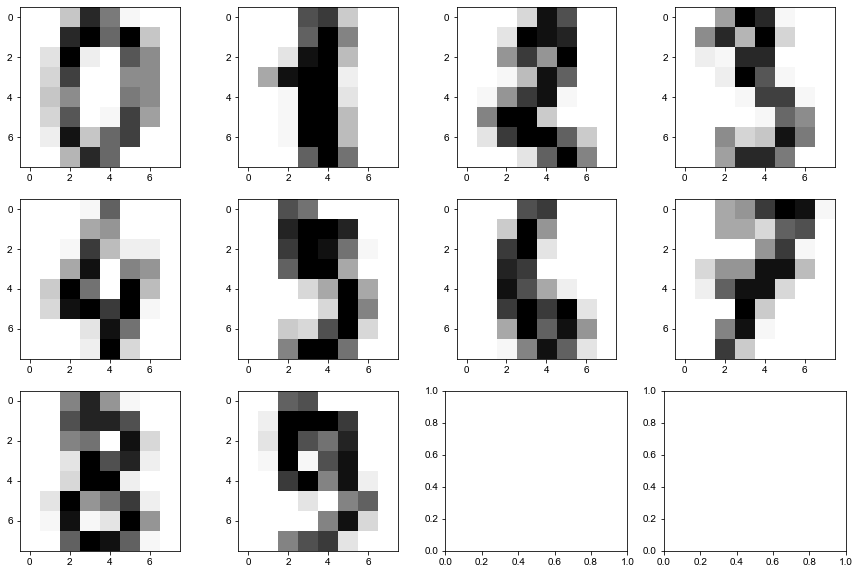

In [6]:
plt.gray()
fig, ax = plt.subplots(3, 4, figsize=(15,10))
sns.set_theme()
plt.style.use('seaborn')
ax[0, 0].imshow(digits.images[0], interpolation='none')
ax[0, 0].grid(False)
ax[0, 1].imshow(digits.images[1], interpolation='none')
ax[0, 1].grid(False)
ax[0, 2].imshow(digits.images[2], interpolation='none')
ax[0, 2].grid(False)
ax[0, 3].imshow(digits.images[3], interpolation='none')
ax[0, 3].grid(False)
ax[1, 0].imshow(digits.images[4], interpolation='none')
ax[1, 0].grid(False)
ax[1, 1].imshow(digits.images[5], interpolation='none')
ax[1, 1].grid(False)
ax[1, 2].imshow(digits.images[6], interpolation='none')
ax[1, 2].grid(False)
ax[1, 3].imshow(digits.images[7], interpolation='none')
ax[1, 3].grid(False)
ax[2, 0].imshow(digits.images[8], interpolation='none')
ax[2, 0].grid(False)
ax[2, 1].imshow(digits.images[9], interpolation='none')
ax[2, 1].grid(False)
plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [7]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=10, n_init=100)
model.fit(digits.data)
labels_kmeans = model.predict(digits.data)

<mark>**Проведем кросстабуляцию**<mark>

In [8]:
import pandas as pd
df = pd.DataFrame({'clusters': labels_kmeans, 'digits': digits.target})

In [9]:
ct = pd.crosstab(df['clusters'], df['digits'])

In [10]:
ct

digits,0,1,2,3,4,5,6,7,8,9
clusters,,,,,,,,,,
0,0,2,0,0,0,1,177,0,2,0
1,0,0,2,12,0,42,0,0,53,140
2,0,0,4,7,10,0,0,175,5,9
3,0,99,8,7,2,0,2,2,100,1
4,0,1,13,155,0,1,0,0,2,6
5,177,0,1,0,0,0,1,0,0,0
6,1,0,0,0,162,2,0,0,0,0
7,0,24,147,0,0,0,0,0,3,0
8,0,55,2,0,7,0,1,2,5,20


<mark>**Лучше всего k-средних кластеризация выявила цифры 0 и 6. Хуже всего распознана цифра 1.**<mark>

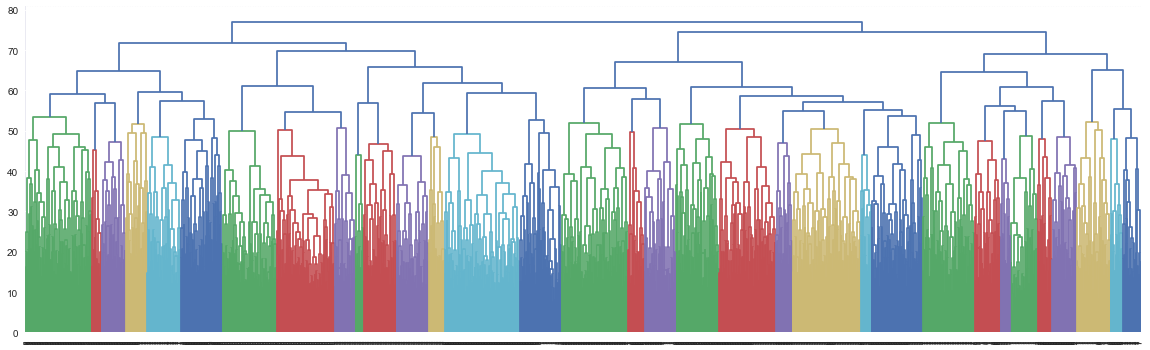

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram
fig = plt.figure(figsize = [20, 6])
mergings = linkage(digits.data, method='complete')
dendrogram(mergings, labels=digits.target, leaf_rotation=90, leaf_font_size=6)
plt.show()

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram, centroid
mergings = linkage(digits.data, method='complete')
from scipy.cluster.hierarchy import fcluster
labels_hier = fcluster(mergings, 64.6, criterion='distance')

<mark>**Проведем кросстабуляцию**<mark>

In [13]:
import pandas as pd
df_hier = pd.DataFrame({'clusters': labels_hier, 'digits': digits.target})

In [14]:
ct_hier = pd.crosstab(df_hier['clusters'], df_hier['digits'])

In [15]:
ct_hier

digits,0,1,2,3,4,5,6,7,8,9
clusters,,,,,,,,,,
1,0,0,0,2,0,138,8,1,0,13
2,0,6,0,0,4,0,1,66,76,2
3,178,0,0,0,32,0,3,0,0,0
4,0,0,0,0,67,0,0,0,0,0
5,0,34,0,0,78,0,149,0,5,0
6,0,27,137,0,0,0,20,0,0,0
7,0,0,27,163,0,44,0,0,19,145
8,0,67,12,17,0,0,0,84,68,0
9,0,48,0,0,0,0,0,0,6,0


<mark>**Лучше всего иерархическая кластеризация выявила цифру 0. Хуже всего распознана цифра 1. Качество k-средних кластеризации выше (меньше разброс).**<mark>

Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

<mark>**Визуализируем центроиды результата k-средних кластеризации.**<mark>

In [16]:
centroids = model.cluster_centers_

<Figure size 576x396 with 0 Axes>

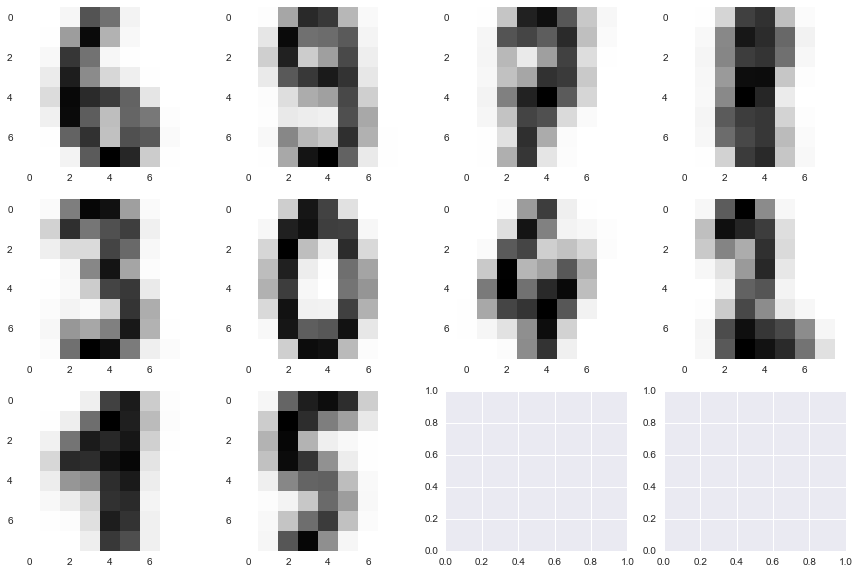

In [17]:
plt.gray()
fig, ax = plt.subplots(3, 4, figsize=(15,10))
sns.set_theme()
plt.style.use('seaborn-white')
ax[0, 0].imshow(centroids[0].reshape(8, 8), interpolation='none')
ax[0, 0].grid(False)
ax[0, 1].imshow(centroids[1].reshape(8, 8), interpolation='none')
ax[0, 1].grid(False)
ax[0, 2].imshow(centroids[2].reshape(8, 8), interpolation='none')
ax[0, 2].grid(False)
ax[0, 3].imshow(centroids[3].reshape(8, 8), interpolation='none')
ax[0, 3].grid(False)
ax[1, 0].imshow(centroids[4].reshape(8, 8), interpolation='none')
ax[1, 0].grid(False)
ax[1, 1].imshow(centroids[5].reshape(8, 8), interpolation='none')
ax[1, 1].grid(False)
ax[1, 2].imshow(centroids[6].reshape(8, 8), interpolation='none')
ax[1, 2].grid(False)
ax[1, 3].imshow(centroids[7].reshape(8, 8), interpolation='none')
ax[1, 3].grid(False)
ax[2, 0].imshow(centroids[8].reshape(8, 8), interpolation='none')
ax[2, 0].grid(False)
ax[2, 1].imshow(centroids[9].reshape(8, 8), interpolation='none')
ax[2, 1].grid(False)
plt.show()

<mark>**Визуализируем средние значения кластеров, полученных иерархической кластеризацией.**<mark>

In [18]:
flat_digits = [i.flatten() for i in digits.data]

In [19]:
flat_df_hier = pd.DataFrame({'data': flat_digits, 'clusters': labels_hier, 'digits': digits.target})

In [20]:
flat_df_hier.head()

,data,clusters,digits
0,"[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0,...",3,0
1,"[0.0, 0.0, 0.0, 12.0, 13.0, 5.0, 0.0, 0.0, 0.0...",8,1
2,"[0.0, 0.0, 0.0, 4.0, 15.0, 12.0, 0.0, 0.0, 0.0...",8,2
3,"[0.0, 0.0, 7.0, 15.0, 13.0, 1.0, 0.0, 0.0, 0.0...",7,3
4,"[0.0, 0.0, 0.0, 1.0, 11.0, 0.0, 0.0, 0.0, 0.0,...",4,4


In [21]:
centroids_hier = flat_df_hier.groupby('clusters')['data'].mean()

In [22]:
mean = [i.reshape(8, 8) for i in centroids_hier]

<Figure size 576x396 with 0 Axes>

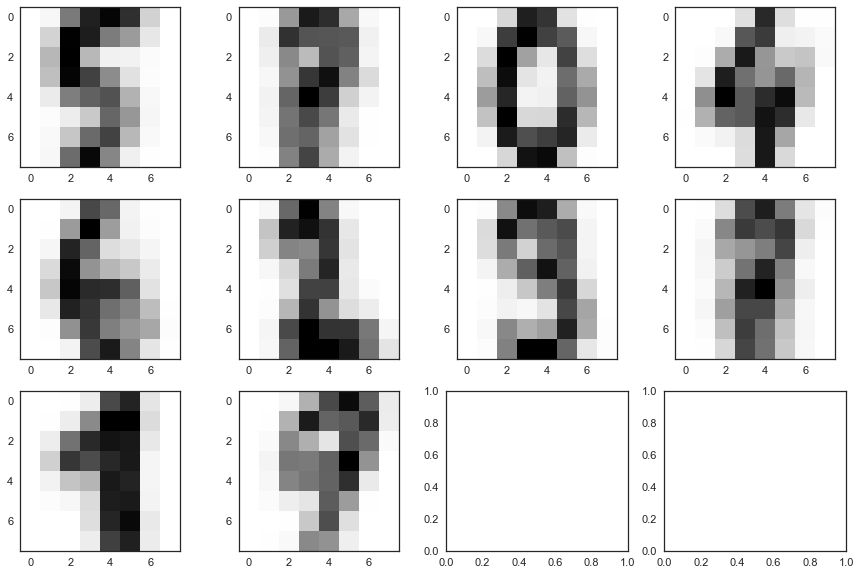

In [23]:
plt.gray()
fig, ax = plt.subplots(3, 4, figsize=(15,10))
sns.set_theme()
plt.style.use('seaborn-white')
ax[0, 0].imshow(mean[0], interpolation='none')
ax[0, 1].imshow(mean[1], interpolation='none')
ax[0, 2].imshow(mean[2], interpolation='none')
ax[0, 3].imshow(mean[3], interpolation='none')
ax[1, 0].imshow(mean[4], interpolation='none')
ax[1, 1].imshow(mean[5], interpolation='none')
ax[1, 2].imshow(mean[6], interpolation='none')
ax[1, 3].imshow(mean[7], interpolation='none')
ax[2, 0].imshow(mean[8], interpolation='none')
ax[2, 1].imshow(mean[9], interpolation='none')
plt.show()

<mark>**Алгоритм k-средних кластрезации даёт центры кластеров, больше похожие на типичные начертания цифр.**<mark>

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [24]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.cluster import AgglomerativeClustering

In [25]:
kmeans_silhouette = []
hier_silhouette = []
kmeans_vmeasure_score = []
hier_vmeasure_score = []

for i in range(2,21):
    model_kmeans = KMeans(n_clusters=i, random_state=0)
    model_kmeans.fit(digits.data)
    labels_kmeans = model_kmeans.predict(digits.data)
    
    silhouette_kmeans = silhouette_score(digits.data, labels_kmeans)
    kmeans_silhouette.append(silhouette_kmeans)    
    
    model_hier = AgglomerativeClustering(n_clusters=i)
    labels_hier = model_hier.fit_predict(digits.data)
    
    silhouette_hier = silhouette_score(digits.data, labels_hier)
    hier_silhouette.append(silhouette_hier)
    
    v_measure_kmeans = v_measure_score(digits.target, labels_kmeans)
    kmeans_vmeasure_score.append(v_measure_kmeans)
    
    v_measure_hier = v_measure_score(digits.target, labels_hier)
    hier_vmeasure_score.append(v_measure_hier) 

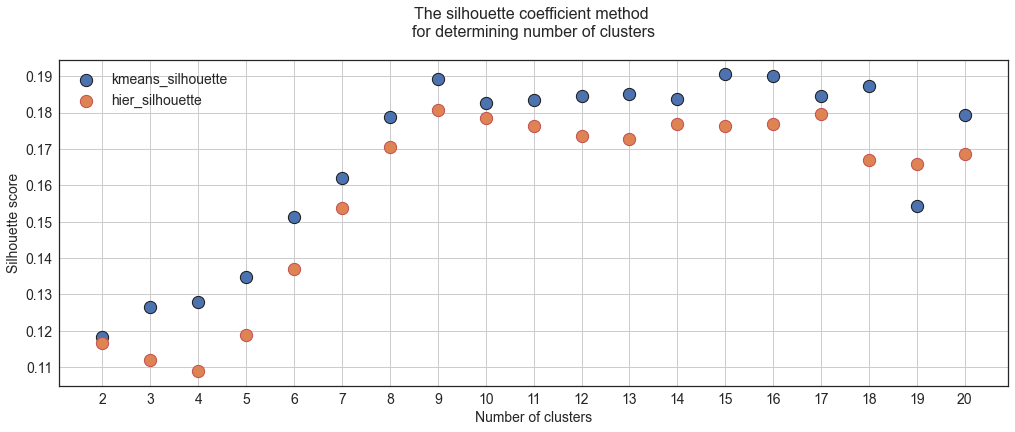

In [26]:
plt.figure(figsize=(17,6))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,21)],y=kmeans_silhouette,s=150,edgecolor='k', label='kmeans_silhouette')
plt.scatter(x=[i for i in range(2,21)],y=hier_silhouette,s=150,edgecolor='r', label='hier_silhouette')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=14)
plt.xticks([i for i in range(2,21)],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

<mark>**Согласно графику выше максимум силуэта достигается при 9 кластерах, хотя мы знаем, что кластеров 10.**<mark>

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

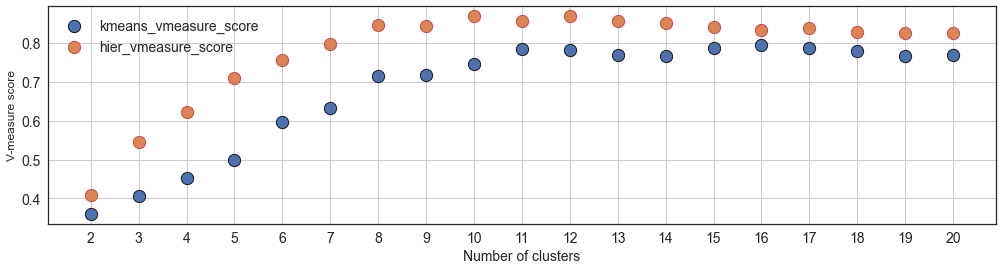

In [27]:
plt.figure(figsize=(17,4))
plt.scatter(x=[i for i in range(2,21)],y=kmeans_vmeasure_score,s=150,edgecolor='k', label='kmeans_vmeasure_score')
plt.scatter(x=[i for i in range(2,21)],y=hier_vmeasure_score,s=150,edgecolor='r', label='hier_vmeasure_score')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("V-measure score")
plt.xticks([i for i in range(2,21)],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

<mark>**Согласно графику выше максимум v-меры достигается при 10 кластерах при иерархической кластеризации и при 11 кластерах при k-средних кластеризации.**<mark>

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [28]:
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

features = [2, 5, 10, 20]

kmeans_silhouette_svd = []
hier_silhouette_svd = []
kmeans_vmeasure_score_svd = []
hier_vmeasure_score_svd = []

for i in features:
    model_svd = TruncatedSVD(n_components=i)
    model_svd.fit(digits.data)
    model_svd_transformed = model_svd.transform(digits.data)
    
    model_kmeans = KMeans(n_clusters=10, random_state=0)
    model_kmeans.fit(model_svd_transformed)
    labels_kmeans = model_kmeans.predict(model_svd_transformed) 
        
    silhouette_kmeans = silhouette_score(model_svd_transformed, labels_kmeans)
    kmeans_silhouette_svd.append(silhouette_kmeans)
    
    model_hier = AgglomerativeClustering(n_clusters=10)
    labels_hier = model_hier.fit_predict(model_svd_transformed)
    
    silhouette_hier = silhouette_score(model_svd_transformed, labels_hier)
    hier_silhouette_svd.append(silhouette_hier)
    
    v_measure_kmeans = v_measure_score(digits.target, labels_kmeans)
    kmeans_vmeasure_score_svd.append(v_measure_kmeans)
    
    v_measure_hier = v_measure_score(digits.target, labels_hier)
    hier_vmeasure_score_svd.append(v_measure_hier) 

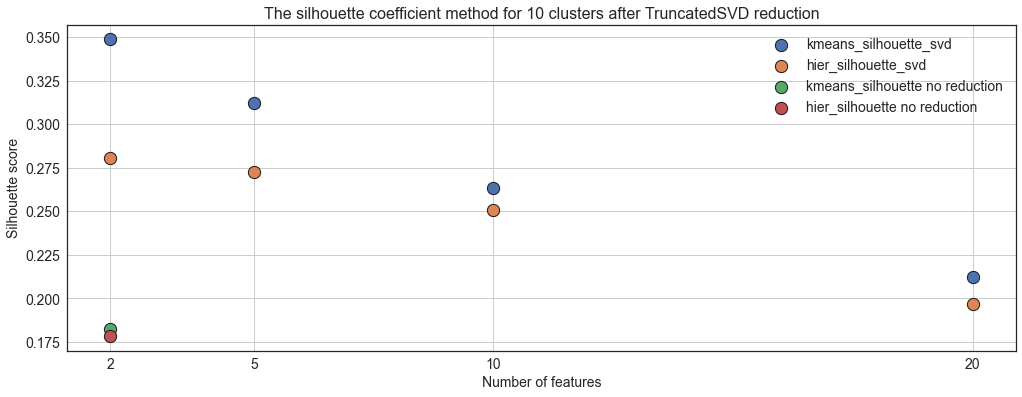

In [29]:
plt.figure(figsize=(17,6))
plt.title("The silhouette coefficient method for 10 clusters after TruncatedSVD reduction",fontsize=16)
plt.scatter(x=features,y=kmeans_silhouette_svd,s=150,edgecolor='k', label='kmeans_silhouette_svd')
plt.scatter(x=features,y=hier_silhouette_svd,s=150,edgecolor='k', label='hier_silhouette_svd')
plt.scatter(x=2,y=kmeans_silhouette[8],s=150,edgecolor='k', label='kmeans_silhouette no reduction')
plt.scatter(x=2,y=hier_silhouette[8],s=150,edgecolor='k', label='hier_silhouette no reduction')
plt.grid(True)
plt.xlabel("Number of features",fontsize=14)
plt.ylabel("Silhouette score",fontsize=14)
plt.xticks(features,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

<mark>**После снижения размерности с помощью TruncatedSVD максимальная метрика силуэта при k-средних и при иерархической кластеризации была достигнута при количестве признаков 2.**<mark>

<mark>**После снижения размерности с помощью TruncatedSVD при любом количестве признаков метрика силуэта оказалась выше как при k-средних так и при иерархической кластеризации.**<mark>

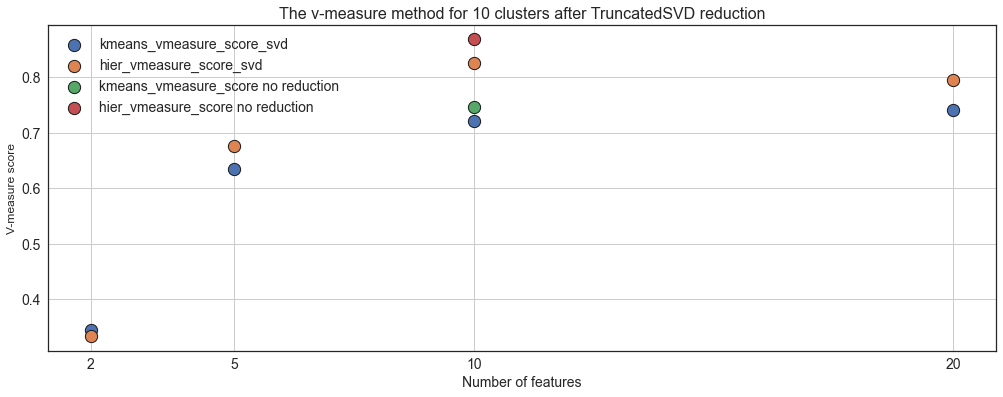

In [30]:
plt.figure(figsize=(17,6))
plt.title("The v-measure method for 10 clusters after TruncatedSVD reduction",fontsize=16)
plt.scatter(x=features,y=kmeans_vmeasure_score_svd,s=150,edgecolor='k', label='kmeans_vmeasure_score_svd')
plt.scatter(x=features,y=hier_vmeasure_score_svd,s=150,edgecolor='k', label='hier_vmeasure_score_svd')
plt.scatter(x=10,y=kmeans_vmeasure_score[8],s=150,edgecolor='k', label='kmeans_vmeasure_score no reduction')
plt.scatter(x=10,y=hier_vmeasure_score[8],s=150,edgecolor='k', label='hier_vmeasure_score no reduction')
plt.grid(True)
plt.xlabel("Number of features",fontsize=14)
plt.ylabel("V-measure score")
plt.xticks(features,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

<mark>**После снижения размерности с помощью TruncatedSVD максимальная v-метрика при k-средних была достигнута при 20 признаках, а при иерархической кластеризации при 10 признаках.**<mark>

<mark>**При любом количестве признаков v-метрика после снижения размерности с помощью TruncatedSVD ниже как при k-средних так и при иерархической кластеризации по сравнению с кластеризацией на исходных данных.**<mark>

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [31]:
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
model_tsne_transformed = model_tsne.fit_transform(digits.data)

C:\Users\myshk\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\myshk\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


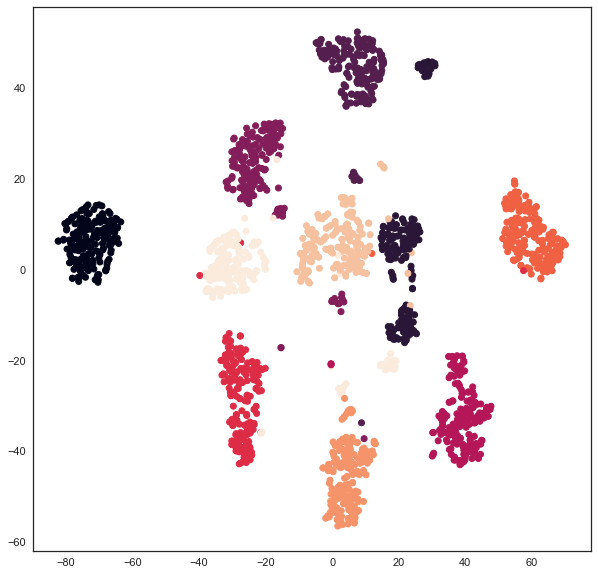

In [32]:
sns.set_style("white")
plt.figure(figsize=(10, 10))
xs = model_tsne_transformed[:, 0]
ys = model_tsne_transformed[:, 1]
plt.scatter(xs, ys, c=digits.target)

Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [33]:
model_tsne_kmeans = KMeans(n_clusters=10, random_state=0)
model_tsne_kmeans.fit(model_tsne_transformed)
labels_tsne_kmeans = model_tsne_kmeans.predict(model_tsne_transformed) 
        
silhouette_tsne_kmeans = silhouette_score(model_tsne_transformed, labels_tsne_kmeans)
    
model_tsne_hier = AgglomerativeClustering(n_clusters=10)
labels_tsne_hier = model_tsne_hier.fit_predict(model_tsne_transformed)
    
silhouette_tsne_hier = silhouette_score(model_tsne_transformed, labels_tsne_hier)
    
v_measure_tsne_kmeans = v_measure_score(digits.target, labels_tsne_kmeans)
    
v_measur_tsnee_hier = v_measure_score(digits.target, labels_tsne_hier)


In [34]:
df_metrics = pd.DataFrame({'Silhouette original': [kmeans_silhouette[8], hier_silhouette[8]], 
                           'Silhouette SVD': [kmeans_silhouette_svd[0], hier_silhouette_svd[0]],
                           'Silhouette TSNE': [silhouette_tsne_kmeans, silhouette_tsne_hier], 
                           'V-measure original': [kmeans_vmeasure_score[8], hier_vmeasure_score[8]], 
                           'V-measure SVD': [kmeans_vmeasure_score_svd[3], hier_vmeasure_score_svd[2]], 
                           'V-measure TSNE': [v_measure_tsne_kmeans, v_measur_tsnee_hier]}, index=['K-means', 'Hierarchical'])

In [35]:
df_metrics

,Silhouette original,Silhouette SVD,Silhouette TSNE,V-measure original,V-measure SVD,V-measure TSNE
K-means,0.182519,0.348560,0.638725,0.746877,0.741430,0.907887
Hierarchical,0.178497,0.280817,0.638868,0.868170,0.825975,0.908745


<mark>**Силуэт и v-метрика показали лучший после снижения размерности методом TSNE, но в TSNE нет inverse_transform(X).**<mark>

<mark>**Проверим силуэт и v-метрику после снижения размерности методом PCA.**<mark>

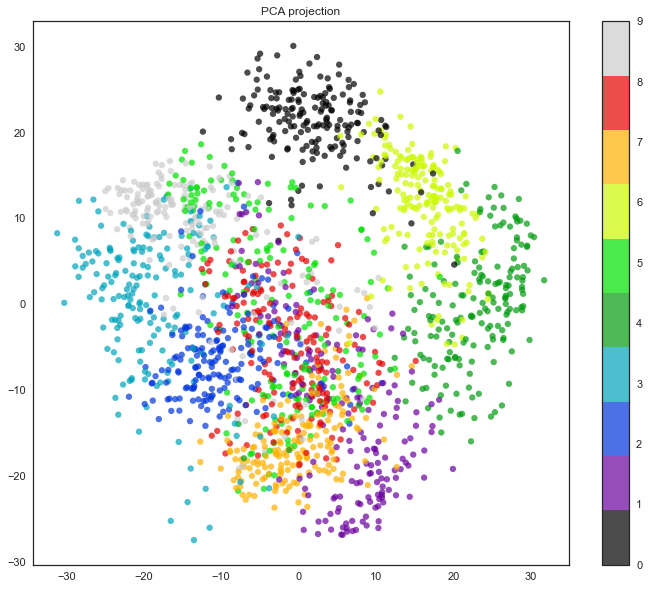

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=21)
digits_pca = pca.fit_transform(digits.data)

plt.figure(figsize=(12,10))
plt.scatter(digits_pca[:, 0], digits_pca[:, 1], c=digits.target, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('PCA projection');

In [37]:
model_pca_kmeans = KMeans(n_clusters=10, random_state=0)
model_pca_kmeans.fit(digits_pca)
labels_pca_kmeans = model_pca_kmeans.predict(digits_pca) 
silhouette_pca_kmeans = silhouette_score(digits_pca, labels_pca_kmeans)
v_measure_pca_kmeans = v_measure_score(digits.target, labels_pca_kmeans)

In [38]:
model_pca_hier = AgglomerativeClustering(n_clusters=10)
labels_pca_hier = model_pca_hier.fit_predict(digits_pca)
silhouette_pca_hier = silhouette_score(digits_pca, labels_pca_hier)
v_measure_pca_hier = v_measure_score(digits.target, labels_pca_hier)

In [39]:
df_metrics = pd.DataFrame({'Silhouette original': [kmeans_silhouette[8], hier_silhouette[8]], 
                           'Silhouette SVD': [kmeans_silhouette_svd[0], hier_silhouette_svd[0]],
                           'Silhouette PCA': [silhouette_pca_kmeans, silhouette_pca_hier],
                           'Silhouette TSNE': [silhouette_tsne_kmeans, silhouette_tsne_hier], 
                           'V-measure original': [kmeans_vmeasure_score[8], hier_vmeasure_score[8]], 
                           'V-measure SVD': [kmeans_vmeasure_score_svd[3], hier_vmeasure_score_svd[2]], 
                           'V-measure PCA': [v_measure_pca_kmeans, v_measure_pca_hier],
                           'V-measure TSNE': [v_measure_tsne_kmeans, v_measur_tsnee_hier],
                           }, index=['K-means', 'Hierarchical'])

In [40]:
df_metrics

,Silhouette original,Silhouette SVD,Silhouette PCA,Silhouette TSNE,V-measure original,V-measure SVD,V-measure PCA,V-measure TSNE
K-means,0.182519,0.348560,0.210008,0.638725,0.746877,0.741430,0.744755,0.907887
Hierarchical,0.178497,0.280817,0.206719,0.638868,0.868170,0.825975,0.834718,0.908745


<mark>**Лучшие результаты показала кластаризация с помощью k-средних после снижения размерности при помощи TruncatedSVD (20 признаков).**<mark>

Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

<mark>**Визуализируем центориды k-средних (снижение размерности при помощи TruncatedSVD, 20 признаков)**<mark>

In [41]:
model_svd = TruncatedSVD(n_components=20)
model_svd.fit(digits.data)
model_svd_transformed = model_svd.transform(digits.data)
    
model_kmeans = KMeans(n_clusters=10, random_state=0)
model_kmeans.fit(model_svd_transformed)
labels_kmeans = model_kmeans.predict(model_svd_transformed) 
        
silhouette_kmeans = silhouette_score(model_svd_transformed, labels_kmeans)
kmeans_silhouette_svd.append(silhouette_kmeans)

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(digits.target, labels_kmeans)

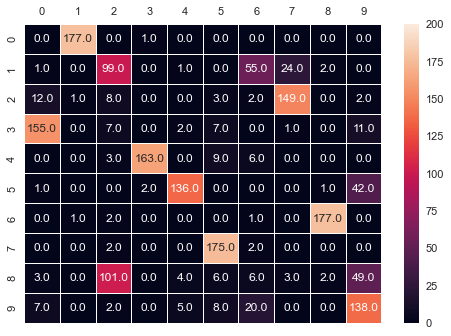

In [43]:
df_cm = pd.DataFrame(confusion_matrix)
ax = sns.heatmap(df_cm, annot=True, fmt=".1f", linewidth=.5, vmax=200)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

<mark>**Добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре, не удалось.**<mark>

In [44]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(model_svd_transformed, labels_kmeans)

NearestCentroid()

In [45]:
svd_centroids = clf.centroids_

In [46]:
digits_svd_reconstructed  = model_svd.inverse_transform(svd_centroids)

<Figure size 576x396 with 0 Axes>

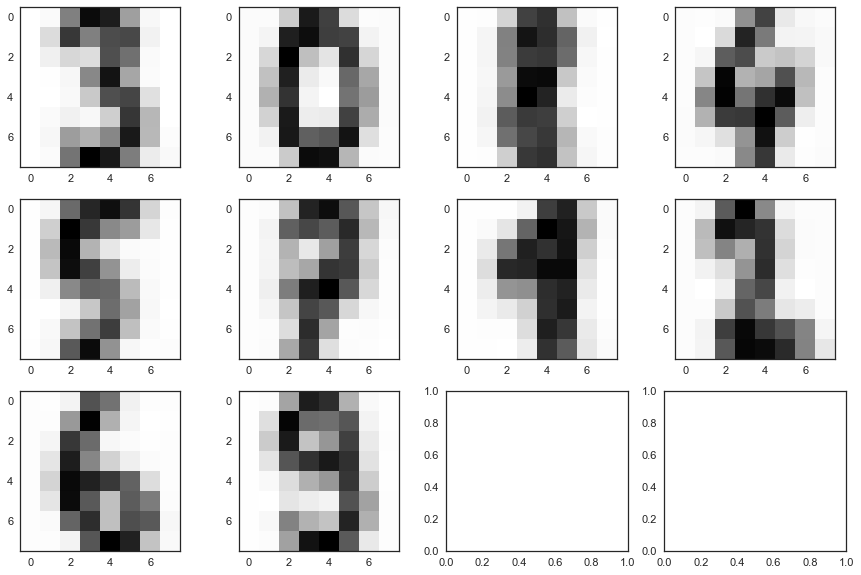

In [47]:
plt.gray()
fig, ax = plt.subplots(3, 4, figsize=(15,10))
sns.set_theme()
plt.style.use('seaborn-white')
ax[0, 0].imshow(digits_svd_reconstructed[0].reshape(8, 8), interpolation='none')
ax[0, 0].grid(False)
ax[0, 1].imshow(digits_svd_reconstructed[1].reshape(8, 8), interpolation='none')
ax[0, 1].grid(False)
ax[0, 2].imshow(digits_svd_reconstructed[2].reshape(8, 8), interpolation='none')
ax[0, 2].grid(False)
ax[0, 3].imshow(digits_svd_reconstructed[3].reshape(8, 8), interpolation='none')
ax[0, 3].grid(False)
ax[1, 0].imshow(digits_svd_reconstructed[4].reshape(8, 8), interpolation='none')
ax[1, 0].grid(False)
ax[1, 1].imshow(digits_svd_reconstructed[5].reshape(8, 8), interpolation='none')
ax[1, 1].grid(False)
ax[1, 2].imshow(digits_svd_reconstructed[6].reshape(8, 8), interpolation='none')
ax[1, 2].grid(False)
ax[1, 3].imshow(digits_svd_reconstructed[7].reshape(8, 8), interpolation='none')
ax[1, 3].grid(False)
ax[2, 0].imshow(digits_svd_reconstructed[8].reshape(8, 8), interpolation='none')
ax[2, 0].grid(False)
ax[2, 1].imshow(digits_svd_reconstructed[9].reshape(8, 8), interpolation='none')
ax[2, 1].grid(False)
plt.show()

<mark>**Визуализируем центориды k-средних (снижение размерности при помощи PCA, 21 компонент)**<mark>

In [48]:
centroids_pca = model_pca_kmeans.cluster_centers_

In [49]:
centroids_pca_reconstructed  = pca.inverse_transform(centroids_pca)

<Figure size 576x396 with 0 Axes>

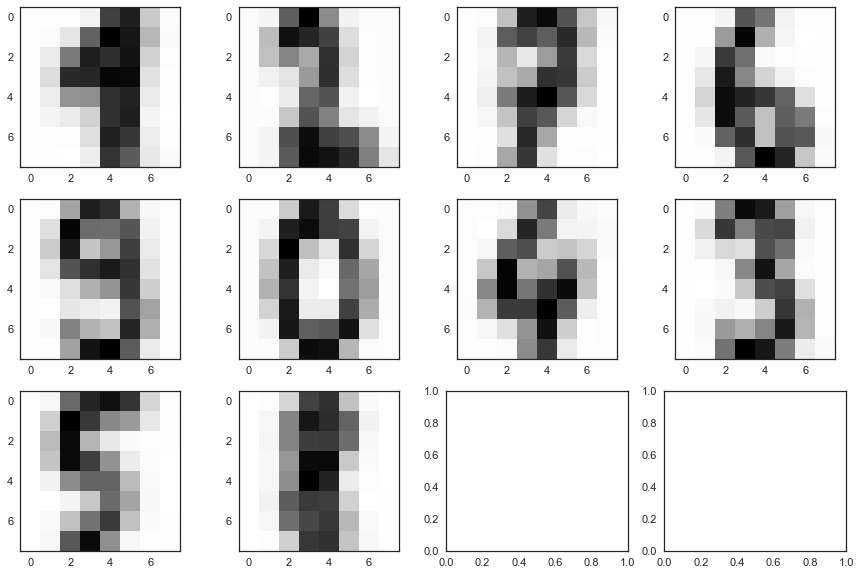

In [50]:
plt.gray()
fig, ax = plt.subplots(3, 4, figsize=(15,10))
sns.set_theme()
plt.style.use('seaborn-white')
ax[0, 0].imshow(centroids_pca_reconstructed[0].reshape(8, 8), interpolation='none')
ax[0, 0].grid(False)
ax[0, 1].imshow(centroids_pca_reconstructed[1].reshape(8, 8), interpolation='none')
ax[0, 1].grid(False)
ax[0, 2].imshow(centroids_pca_reconstructed[2].reshape(8, 8), interpolation='none')
ax[0, 2].grid(False)
ax[0, 3].imshow(centroids_pca_reconstructed[3].reshape(8, 8), interpolation='none')
ax[0, 3].grid(False)
ax[1, 0].imshow(centroids_pca_reconstructed[4].reshape(8, 8), interpolation='none')
ax[1, 0].grid(False)
ax[1, 1].imshow(centroids_pca_reconstructed[5].reshape(8, 8), interpolation='none')
ax[1, 1].grid(False)
ax[1, 2].imshow(centroids_pca_reconstructed[6].reshape(8, 8), interpolation='none')
ax[1, 2].grid(False)
ax[1, 3].imshow(centroids_pca_reconstructed[7].reshape(8, 8), interpolation='none')
ax[1, 3].grid(False)
ax[2, 0].imshow(centroids_pca_reconstructed[8].reshape(8, 8), interpolation='none')
ax[2, 0].grid(False)
ax[2, 1].imshow(centroids_pca_reconstructed[9].reshape(8, 8), interpolation='none')
ax[2, 1].grid(False)
plt.show()

<mark>**Визуально PCA выглядит качественнее, хотя разница небольшая.**<mark>

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

<mark>**Алгоритм  k-средних даёт более осмысленные кластеры, чем иерархическая кластеризация. 
Результат зависит от настроек каждого алгоритма (особенно важно верно выбрать количество кластеров при отсуствии меток).
Метрики качества кластеризации значительно не отличаются. Силуэт выше у алгоритма  k-средних, v-мера выше у иерархической кластеризаци.**<mark>

Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.